# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn.preprocessing
import random
import joblib

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import MinMaxScaler
from implicit.als import AlternatingLeastSquares
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
RANDOM_STATE = 0

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet


Данные о треках — в файле tracks.parquet:
- track_id — идентификатор музыкального трека;
- albums — список идентификаторов альбомов, содержащих трек;
- artists — список идентификаторов исполнителей трека;
- genres — список идентификаторов жанров, к которым принадлежит трек.

Имена артистов, названия альбомов, треков и жанров — в файле catalog_names.parquet:
- id — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
- type — тип идентификатора;
- name — имя (название) каталожной единицы.

Данные о том, какие пользователи прослушали тот или иной трек, — в файле interactions.parquet:
- user_id — идентификатор пользователя,
- track_id — идентификатор музыкального трека,
- track_seq — номер места трека в истории пользователя,
- started_at — дата начала прослушивания трека.

In [7]:
# Загрузим данные
tracks = pd.read_parquet("data/tracks.parquet")
catalog_names = pd.read_parquet("data/catalog_names.parquet")
interactions = pd.read_parquet("data/interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [8]:
# Посмотрим на структуру данных
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [9]:
# Посмотрим на данные
tracks.sample(3)

,track_id,albums,artists,genres
133615,2564235,"[261469, 2457924, 2459149, 2601499, 2602992, 4...","[29044, 29047, 4907812]",[11]
156890,3968487,"[446691, 461984]",[1478],"[26, 74]"
689808,50598681,"[7000323, 20743251]",[6870002],[11]


In [10]:
# Проверим дубликаты
tracks.track_id.duplicated().sum()

0

In [11]:
# Проверим наличие пустых массивов в строках
has_empty_array = tracks[['albums','artists','genres']].apply(lambda row: any(arr.size == 0 for arr in row), axis=1)

# Вывод строк с пустыми массивами
empty_array_rows = tracks[has_empty_array]

print(f'Количество строк с пустыми массивами: {round(empty_array_rows.shape[0]/tracks.shape[0]*100, 2)} %')
display(empty_array_rows)

Количество строк с пустыми массивами: 1.9 %


,track_id,albums,artists,genres
490,2520,"[249, 163801, 163802, 324616, 17542430, 189498...",[2259],[]
3069,16776,"[1479, 5319, 6093, 8467, 10641, 90867, 163801,...",[978],[]
3077,16801,"[1479, 163801, 9287549, 9377183, 9424994, 1201...",[10520],[]
4192,23752,"[2001, 3722, 4973, 6104, 6558, 23866, 37052, 7...",[13373],[]
6645,38012,"[3147, 60099, 530836, 1115289, 2490724, 818446...",[16758],[]
...,...,...,...,...
999868,101201589,[12649219],[],"[62, 77]"
999876,101219571,[9444321],[],"[62, 83, 77]"
999901,101243616,[11700332],[],"[62, 93]"
999920,101292599,[9331881],[],"[62, 90, 77, 84]"


Данных с пропусками менее 2 процентов. Их можно удалить.

In [12]:
# Удалим пропуски
tracks_clean = tracks[~has_empty_array].reset_index(drop=True)

In [13]:
# Сохраним очищенный датасет
tracks_clean.to_parquet('data/tracks_clean.parquet')

In [14]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [15]:
# Выведем несколько строк
catalog_names.sample(3)

,id,type,name
1713427,75364680,track,Истории Слушателей 32
1576685,58657349,track,hello!
1129983,20585209,track,Архистратиг


In [16]:
# Проверим количество дублирующихся каталожных единиц
print(catalog_names.id.duplicated().sum())

print(f'Количество дублирующихся каталожных единиц: {round(catalog_names.id.duplicated().sum() / catalog_names.shape[0] * 100, 2)} %')

35774
Количество дублирующихся каталожных единиц: 1.97 %


In [17]:
# Выведем пример дублирующихся данных
catalog_names[catalog_names['id'].isin([416037, 4428, 301328])].sort_values('id')

,id,type,name
1925,4428,album,"Tatum Group Masterpieces, Vol 2"
659819,4428,artist,Charles Aznavour
813477,4428,track,Heaven Must Have Sent You
56254,301328,album,Success Is Certain [Clean]
849141,301328,track,Running Free
682286,301328,artist,Dirty Red
60818,416037,album,ROCK ANTHEMS VOL-6
687015,416037,artist,The Snake
860021,416037,track,The Power of Thy Sword


Похоже, что каталожные единицы могут быть с дублирующимися id, поскольку это разные типы единиц (трек, альбом, жанр). Можно не удалять дублирующиеся id.

In [18]:
# Проверим дублирующиеся строки
catalog_names[catalog_names.duplicated()]

,id,type,name


In [19]:
# Проверим наличие пропусков
catalog_names[catalog_names.isna().any(axis=1)]

,id,type,name


In [20]:
# Проверим "неизвестных" исполнителей
catalog_names[catalog_names['name']=='Unknown']

,id,type,name
55033,289114,album,Unknown
76078,601828,album,Unknown
228223,3477779,album,Unknown
358680,6152730,album,Unknown
360535,6192254,album,Unknown
414186,7891127,album,Unknown
504301,11271919,album,Unknown
554625,13364758,album,Unknown
561444,13723426,album,Unknown
643164,19671631,album,Unknown


Такой исполнитель есть на я.музыке, а альбомов и треков нет.

In [21]:
catalog_names[catalog_names['name']=='unknown']

,id,type,name
524817,12116653,album,unknown
526549,12190200,album,unknown
1682761,71240864,track,unknown


С названием unknown на сервисе ничего нет. Похоже, это заглушка.

In [22]:
# Удалим неизвестных исполнителей, треки и альбомы
catalog_names_clean = catalog_names[~catalog_names['name'].isin(['unknown', 'Unknown'])].reset_index(drop=True)

In [26]:
# Посмотрим следующий датасет
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [24]:
# Выведем несколько строк
interactions.sample(3)

,user_id,track_id,track_seq,started_at
37,146061,52632240,38,2022-06-12
1112,151753,95424041,1113,2022-12-22
105,196368,14521133,106,2022-04-16


In [23]:
# Проверим наличие пропусков
interactions[interactions.isna().any(axis=1)]

,user_id,track_id,track_seq,started_at


In [24]:
# Проверим дублирующиеся строки
interactions[interactions.duplicated()]

,user_id,track_id,track_seq,started_at


In [91]:
# Посмотрим на самую раннюю дату
interactions['started_at'].min()

Timestamp('2022-01-01 00:00:00')

In [92]:
# Посмотрим на последнюю дату
interactions['started_at'].max()

Timestamp('2022-12-31 00:00:00')

Таким образом, данные о взаимодействиям предствалены за один год.

# Выводы

Приведём выводы по первому знакомству с данными:
- в датасете tracks есть пустые ячейки, а в датасете catalog_names есть дубликаты и строки с значениями "unknown".
- пропуски и дубликаты составляют менее 2% данных. Их можно удалить. 
- строки с значениями "unknown" тоже удалены, чтобы не вносить неопределенность в рекомендации.

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [5]:
# Сделаем признак месяца
interactions["started_at_month"] = pd.to_datetime(interactions["started_at"]).dt.to_period('M').dt.to_timestamp().dt.date

In [26]:
# Получим датасет с количество пользователей и событий по месяцам
interactions_by_month = interactions.groupby("started_at_month").agg(events=("started_at", "count"), 
                                                                     users=("user_id", "nunique")).reset_index()

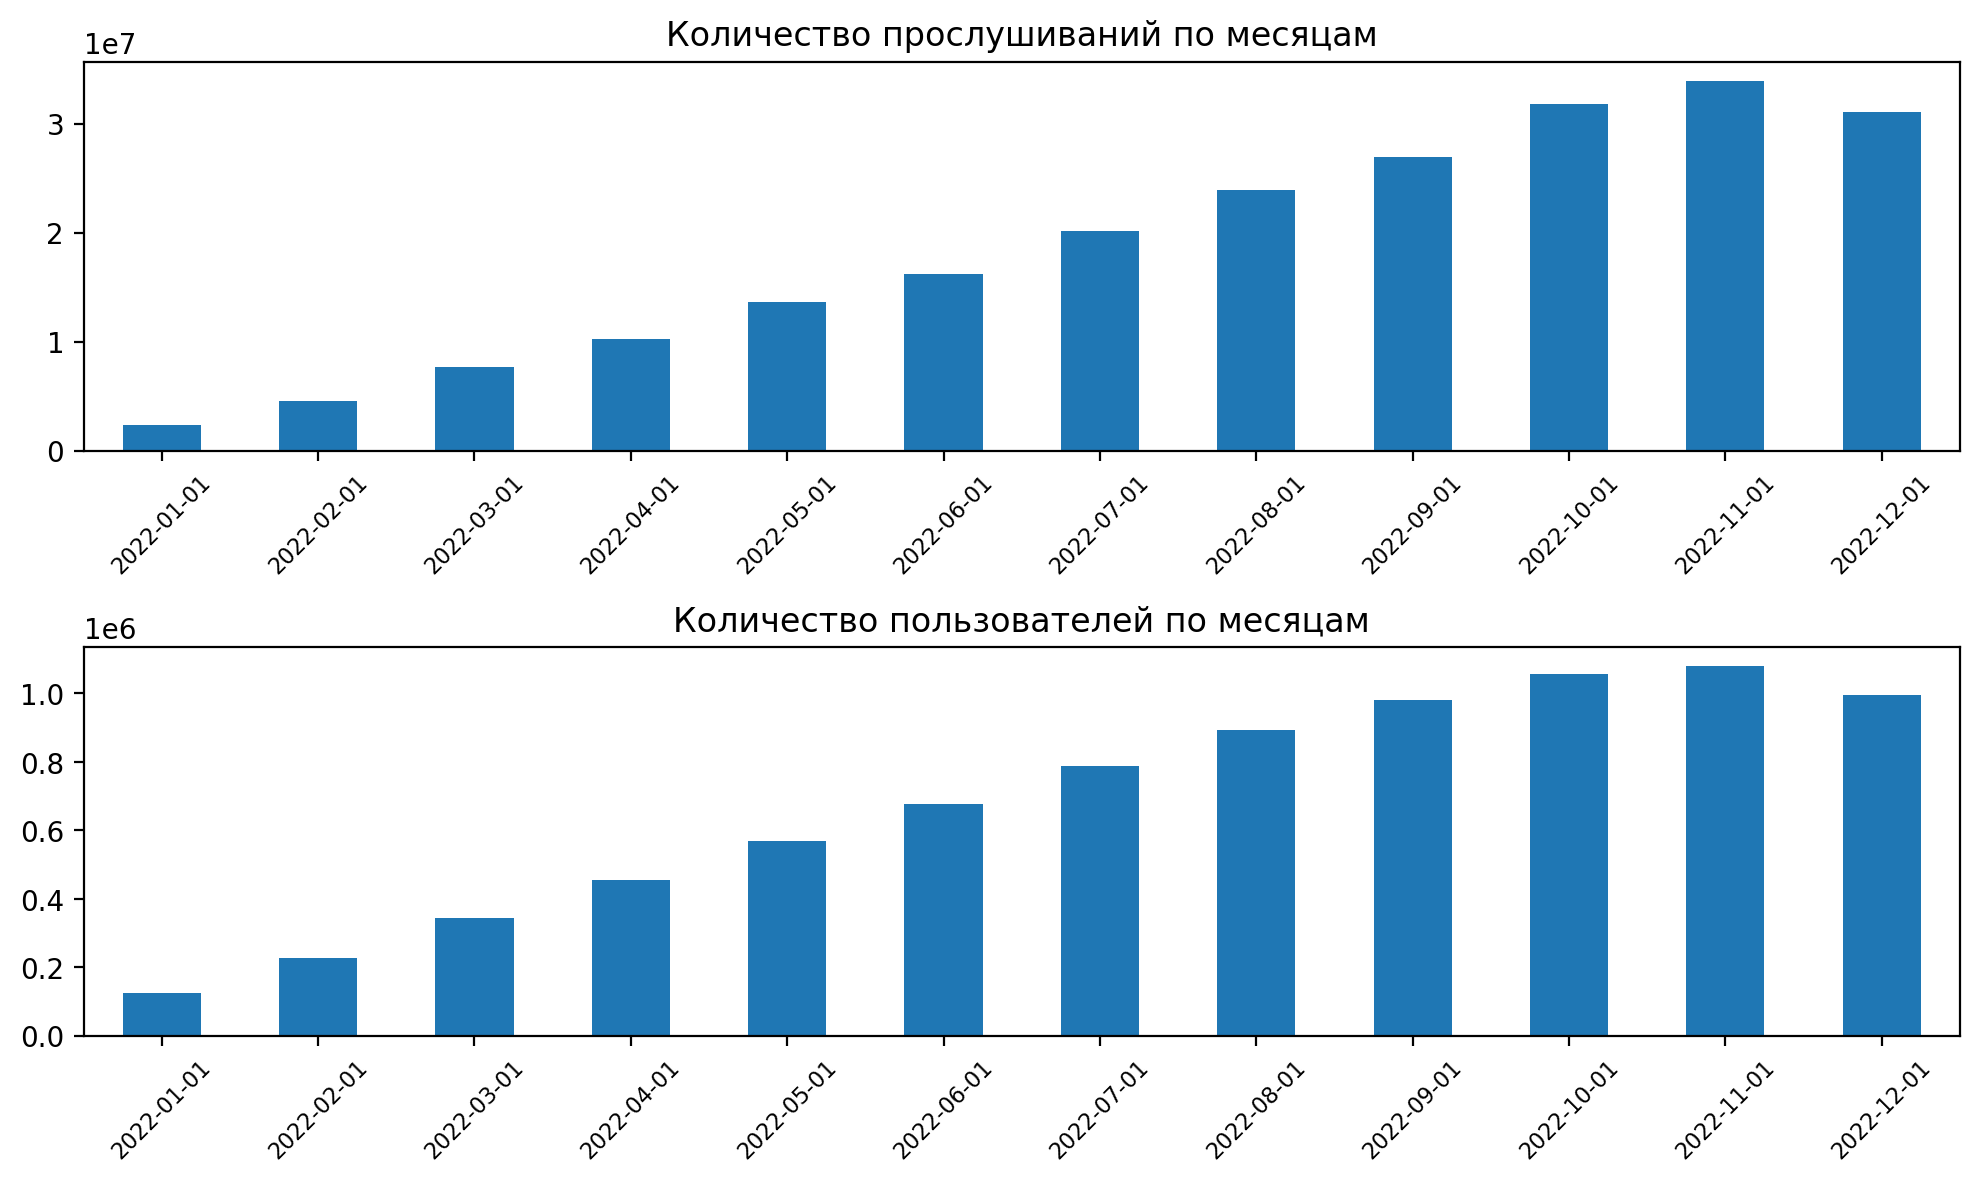

In [27]:
# Построим распределение по месяцам прослушивания

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

ax = axs[0]
interactions_by_month["events"].plot(kind="bar", ax=ax)
ax.set_title('Количество прослушиваний по месяцам')
ax.set_xticklabels(interactions_by_month['started_at_month'], rotation=45)
ax.tick_params(axis='x', labelsize=8)

ax = axs[1]
interactions_by_month["users"].plot(kind="bar", ax=ax)
ax.set_title('Количество пользователей по месяцам')
ax.set_xticklabels(interactions_by_month['started_at_month'], rotation=45)
ax.tick_params(axis='x', labelsize=8)

fig.tight_layout()

## Наиболее популярные треки 

Сохраним топ-10 треков по количеству прослушиваний уникальными пользователями.

In [27]:
# Сохраним сгруппированные данные
top_10_tracks = interactions.groupby('track_id').agg(user_id_count = ('user_id', 'nunique'))\
                                                .sort_values('user_id_count', ascending=False)\
                                                .reset_index().head(10)

In [28]:
# Присоединим названия треков
top_10_tracks = top_10_tracks.merge(catalog_names_clean.rename(columns={'id': 'track_id'}), on=['track_id'], how='left')

In [29]:
# Выведем 10 наиболее популярных треков
top_10_tracks

,track_id,user_id_count,type,name
0,53404,111062,track,Smells Like Teen Spirit
1,33311009,106921,track,Believer
2,178529,101924,track,Numb
3,35505245,99490,track,I Got Love
4,65851540,86670,track,Юность
5,24692821,86246,track,Way Down We Go
6,32947997,85886,track,Shape of You
7,51241318,85244,track,In The End
8,795836,85042,track,Shape Of My Heart
9,45499814,84748,track,Life


## Наиболее популярные жанры

Датасет с событиями занимает слишком много памяти, это непозволяет его обработать. Возьмем только данные по 200000 случайных пользователей.

In [30]:
# Сохраним список с случайными пользователями
users = random.sample(range(0,1374582),200000)

In [31]:
# Создадим усеченную версию датасета
interactions_cut = interactions[interactions['user_id'].isin(users)].reset_index(drop=True)

In [32]:
# Сохраним датасет для дальнейшей работы
interactions_cut.to_parquet('data/interactions_cut.parquet')

In [33]:
# Получается 32 миллиона строк вместо исходных 222 миллионов
interactions_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32544552 entries, 0 to 32544551
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 558.7 MB


In [34]:
# Отберем только необходимые столбцы
tracks_clean_genres = tracks_clean[['track_id', 'genres']].explode('genres')

In [35]:
# Добавим к взаимодействиям информацию о жанрах
events_names = interactions_cut.merge(tracks_clean_genres, on=['track_id'], how='outer')

In [36]:
# Отберем популярные жанры
top_10_genres = events_names.groupby('genres').agg(user_id_count = ('user_id', 'nunique'))\
                                                           .sort_values('user_id_count', ascending=False)\
                                                           .reset_index()\
                                                           .rename(columns={'genres':'genre'})\
                                                           .head(10)

In [37]:
# Выведем результат
top_10_genres.merge(catalog_names_clean[catalog_names_clean['type']=='genre'].rename(columns={'id': 'genre'}), 
                    on='genre', how='left')

,genre,user_id_count,type,name
0,11,183294,genre,pop
1,75,147758,genre,rap
2,102,146111,genre,allrock
3,20,145934,genre,ruspop
4,16,138496,genre,dance
5,68,133967,genre,electronics
6,3,125400,genre,rusrap
7,14,116944,genre,rock
8,25,110313,genre,soundtrack
9,70,108184,genre,indie


Треки, которые никто не прослушал

In [38]:
# Сохраним только данные о треках
tracks = catalog_names_clean[catalog_names_clean['type']=='track'].reset_index(drop=True).rename(columns={'id': 'track_id'})

In [39]:
# Добавим ко всем трекам слушателей
df = tracks.merge(interactions_cut, on='track_id', how='left')

In [40]:
# Выведем треки, для которых не нашлось слушателей
df[df['user_id'].isna()]

,track_id,type,name,user_id,track_seq,started_at
2,38,track,Momma's Boy,NaN,NaN,NaT
3,135,track,Atticus,NaN,NaN,NaT
4,136,track,24 Hours,NaN,NaN,NaT
6,139,track,Wild Young Hearts,NaN,NaN,NaT
114,327,track,Intro,NaN,NaN,NaT
...,...,...,...,...,...,...
32672741,101320779,track,ЦИФРЫ,NaN,NaN,NaT
32672742,101333594,track,Trouble,NaN,NaN,NaT
32672743,101334752,track,For The Squadron,NaN,NaN,NaT
32672771,101362545,track,45. Т-киллеры против рака,NaN,NaN,NaT


In [41]:
# Сохраним уникальные индексы треков из датасета с взаимодействиями
events_track_indx = list(interactions_cut['track_id'].unique())

In [42]:
# Оставим датасет только с теми индесами, которые есть во взаимодействиях
tracks_clean = tracks_clean[tracks_clean['track_id'].isin(events_track_indx)]

In [43]:
# Сохраним индексы треков, для которых есть информация
track_indx = tracks_clean['track_id'].unique()

# Оставим в датасете с взаимодействиями только те треки, по которым есть информация чтобы данные были полными
interactions_cut = interactions_cut[interactions_cut['track_id'].isin(track_indx)]

In [44]:
# Посмотрим на результат
interactions_cut

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22
...,...,...,...,...
32544547,1374578,34686730,7,2022-11-10
32544548,1374578,34726523,8,2022-12-09
32544549,1374578,34976783,9,2022-12-15
32544550,1374578,35279525,10,2022-12-16


Поскольку целиком датасет обработать не представляется возможным на данный момент из-за нехватки ресурсов, будем считать, что для выбранных пользователей число непрослушанных треков достаточно большое. В основном датасете они скорее всего тоже есть.

In [45]:
interactions_cut.to_parquet('data/interactions_cut.parquet')

## Статистика по пользователям

Далее визуализируем, сколько треков слушает каждый пользователь в среднем, распределение количества пользователей в зависимости от числа прослушенных треков и раcпределение по жанрам.

In [10]:
# Среднее количество треков по пользователям за год
average_tracks_per_user = interactions.groupby('user_id').size().mean()
print(f'Среднее количество прослушанных треков на пользователя: {round(average_tracks_per_user, 2)}')

Среднее количество прослушанных треков на пользователя: 162.12


In [6]:
# Получим датасет с количество пользователей и событий по месяцам
interactions_users_by_month = interactions.groupby(['user_id', "started_at_month"]).agg(track_count=("track_id", "count")).reset_index()

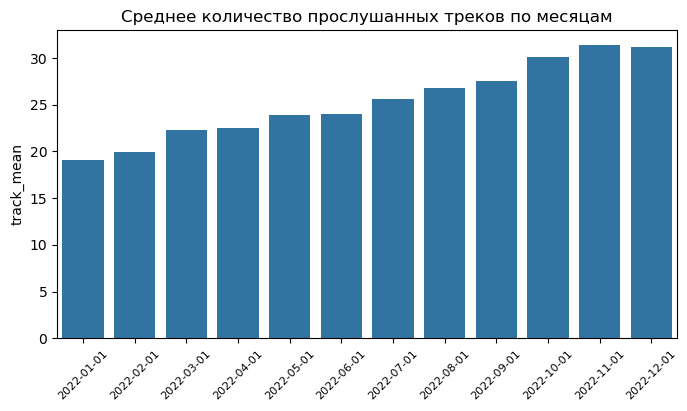

In [9]:
# Посчитаем среднее количество прослушанных треков пользователями в месяц 
interactions_users_by_month_mean = interactions_users_by_month.groupby(["started_at_month"]).agg(track_mean=("track_count", "mean")).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=interactions_users_by_month_mean["track_mean"])
plt.title('Среднее количество прослушанных треков по месяцам')
plt.xticks(ticks=range(len(interactions_users_by_month_mean['started_at_month'])), 
           labels=interactions_users_by_month_mean['started_at_month'], 
           rotation=45)
plt.tick_params(axis='x', labelsize=8)

plt.show()

В среднем пользователи слушают в месяц от 20 до 30 треков. При этом к концу года частота прослушивания увеличивается.

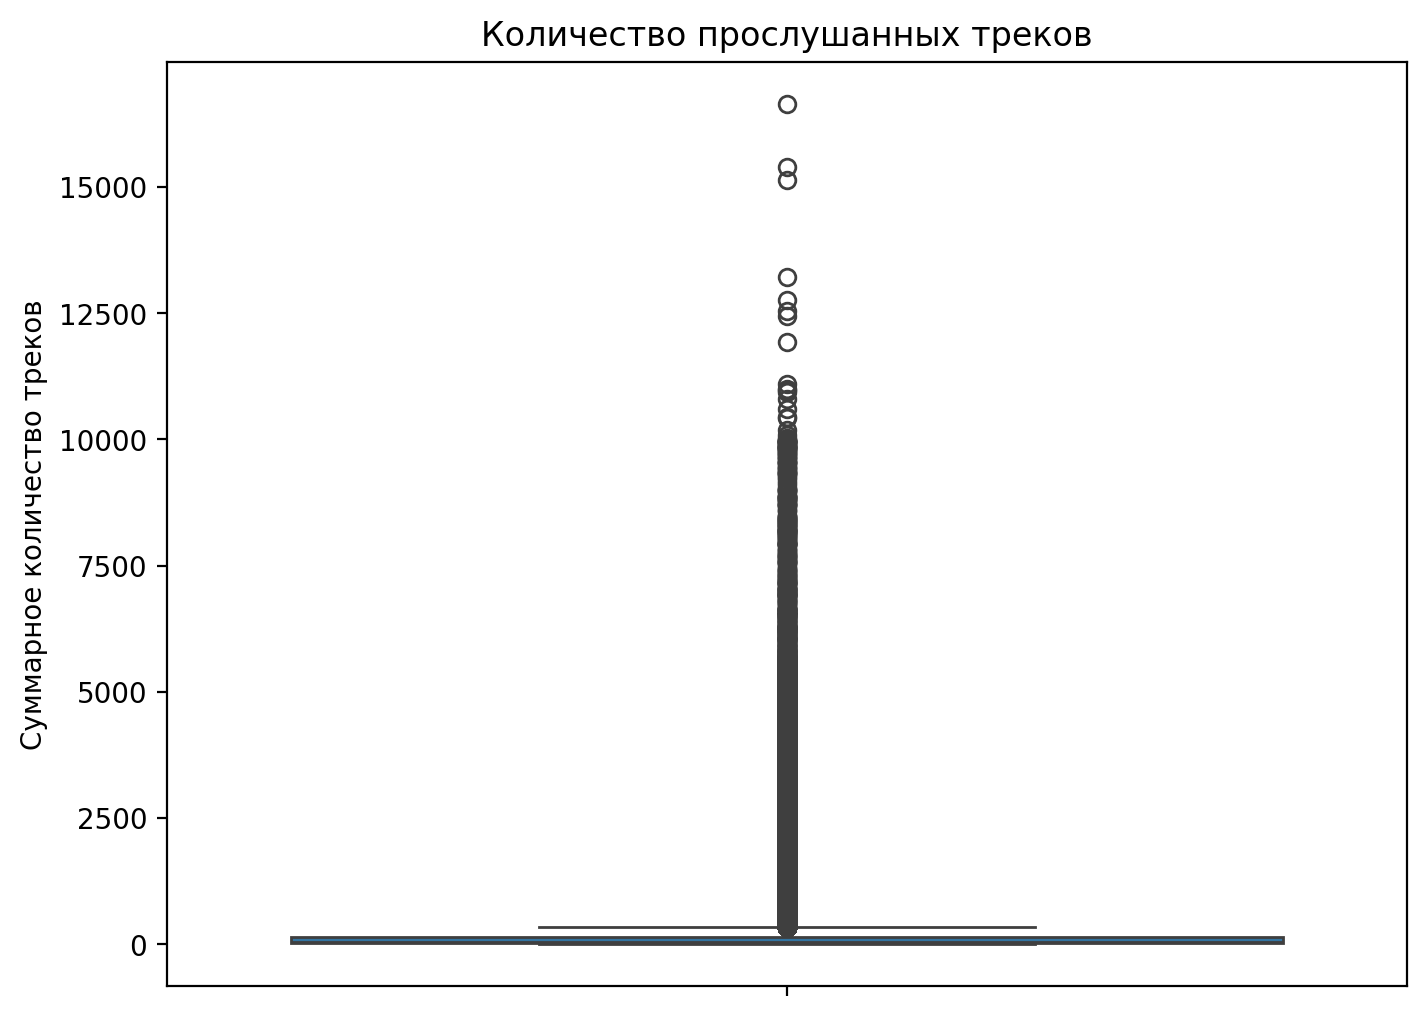

In [29]:
# В отдельной таблице посчитаем суммарное количество прослушанных треков
tracks_boxplot = interactions.groupby('user_id').agg(traks_count = ('track_id', 'count')).reset_index(drop=True)

# Создание графика
plt.figure(figsize=(8, 6))
sns.boxplot(data=tracks_boxplot['traks_count'])

# Настройка заголовка и осей
plt.title('Количество прослушанных треков')
plt.ylabel('Суммарное количество треков')

plt.show()

Основная часть пользователей слушает не более 300 уникальных треков в год. Большое количество пользователей прослушали от 500 до 15000 треков за 2022 год. Сложно оценить, является ли такая статистика неадекватной, а количество взаимодействий - ошибочным. В теории, можно за год повзаимодействовать с 15000 треками за год (не обязательно ведь слушать до конца), а данных о количестве прослушанных секунд у нас нет. 

Далее отсечем пользователей, которые прослушали более 500 треков и подробнее посмотрим на распределение статистик.

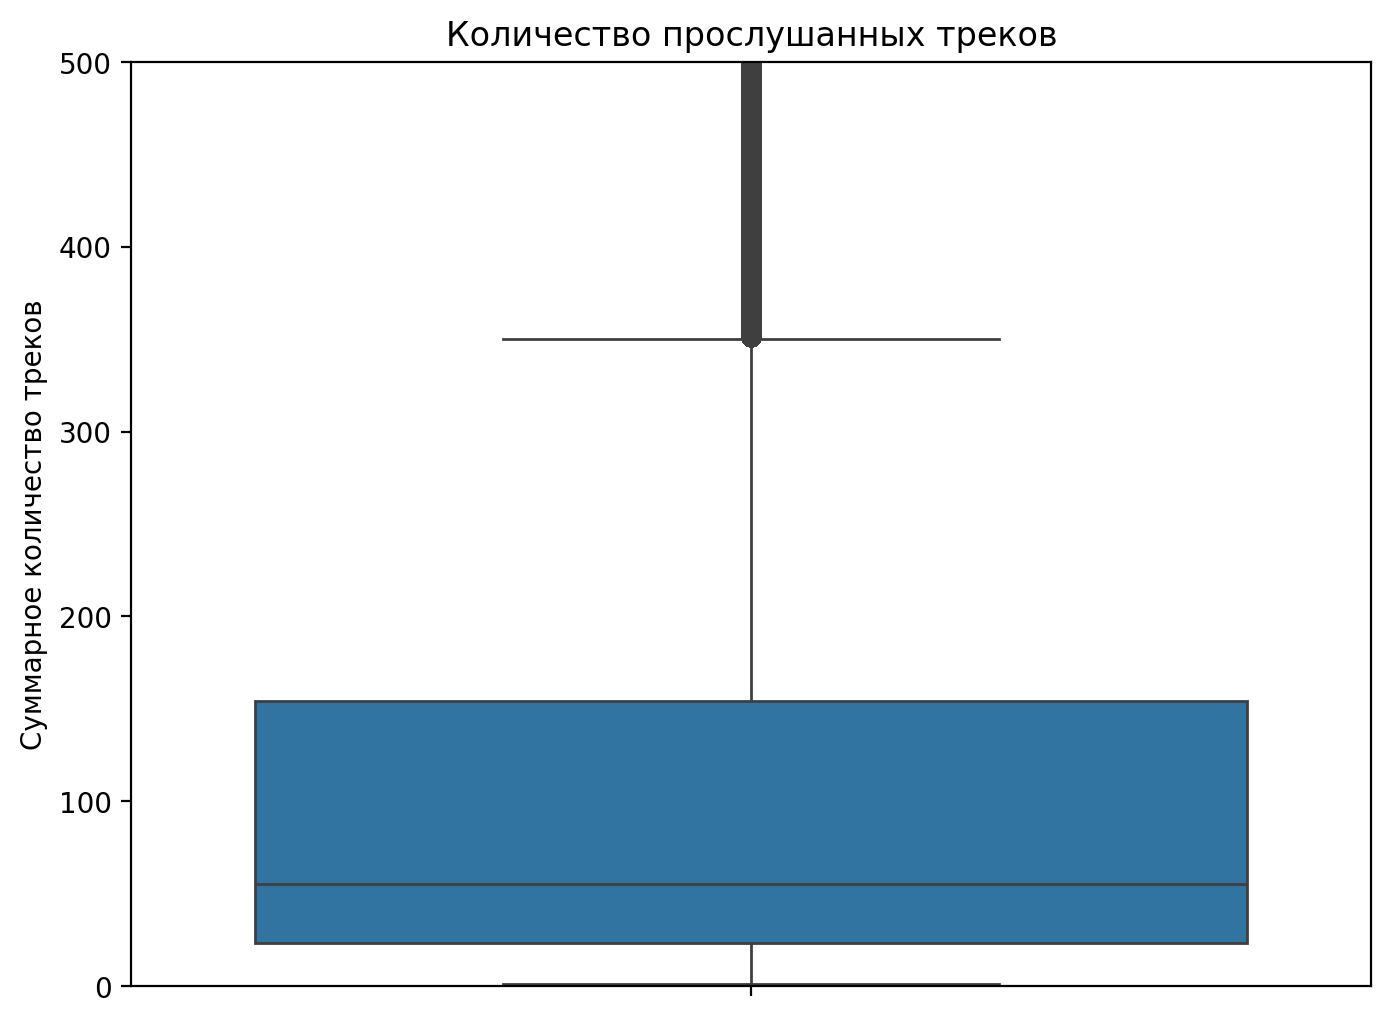

In [38]:
# Создание графика
plt.figure(figsize=(8, 6))
sns.boxplot(data=tracks_boxplot['traks_count'])

ax = plt.gca()

# Настройка заголовка и осей
plt.title('Количество прослушанных треков')
plt.ylabel('Суммарное количество треков')

ax.set_ylim([0, 500])
plt.show()

Таким образом, медианное количество треков, которое прослушали пользователи, составляет 55. Основное распределение сосредоточено между 20 и 150 уникальных трека за год для каждого слушателя.

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций. Для этого необходимо обработать датасет tracks_clean и объединить другие.

In [46]:
# Развернем списки в признаках по одному
tracks_exploded = tracks_clean.explode(['albums']).reset_index(drop=True)
tracks_exploded  = tracks_exploded.explode(['artists']).reset_index(drop=True)
tracks_exploded  = tracks_exploded.explode(['genres']).reset_index(drop=True)

In [47]:
# Преобразуем тип данных
tracks_exploded = tracks_exploded.astype('int')

In [48]:
# Разделим датасет catalog_names по типам
album = catalog_names_clean[catalog_names_clean['type']=='album'].rename(columns={'id':'albums', 
                                                                                  'name': 'name_albums'})[['albums', 'name_albums']]
artist = catalog_names_clean[catalog_names_clean['type']=='artist'].rename(columns={'id':'artists', 
                                                                                    'name': 'name_artists'})[['artists', 'name_artists']]
genre = catalog_names_clean[catalog_names_clean['type']=='genre'].rename(columns={'id':'genres', 
                                                                                  'name': 'name_genres'})[['genres', 'name_genres']]
track = catalog_names_clean[catalog_names_clean['type']=='track'].rename(columns={'id':'track_id', 
                                                                                  'name': 'name_track'})[['track_id', 'name_track']]

In [49]:
# Присоединим данные о треках
tracks_exploded = tracks_exploded.merge(track, on='track_id', how='left')
tracks_exploded = tracks_exploded.merge(album, on='albums', how='left')
tracks_exploded = tracks_exploded.merge(artist, on='artists', how='left')
tracks_exploded = tracks_exploded.merge(genre, on='genres', how='left')

In [50]:
# Проверим пропуски
tracks_exploded.isna().sum()

track_id             0
albums               0
artists              0
genres               0
name_track         395
name_albums         40
name_artists        54
name_genres     174036
dtype: int64

In [51]:
# Посмотрим, какое максимальное количество признаков есть для каждого трека
tracks_exploded['track_id'].value_counts().sort_values()

track_id
63242712        1
63244233        1
2678158         1
63229445        1
63230203        1
            ...  
19214341     6656
18616440     6664
24337242     8397
36447403     9525
24254437    10116
Name: count, Length: 856079, dtype: int64

In [52]:
# Заполнение пропусков любым значением из столбца по track_id
def fill_na_with_group_values(df):
    # Применяем заполнение пропусков ко всем столбцам, кроме 'track_id'
    cols_to_fill = df.columns.tolist()  # Преобразуем индексы в список
    cols_to_fill.remove('track_id')
    for col in cols_to_fill:
        df[col] = df[col].fillna(df[col].transform(lambda x: x.ffill().bfill()))
    return df

# Применяем функцию ко всему датасету
tracks_exploded_filled = fill_na_with_group_values(tracks_exploded)

In [53]:
# Проверим результат
tracks_exploded_filled.isna().sum()

track_id        0
albums          0
artists         0
genres          0
name_track      0
name_albums     0
name_artists    0
name_genres     0
dtype: int64

Поскольку для каждого трека может быть большое количество (более 10000) дополнительных данных (жанр, альбом, исполнитель), оставим только по одному атрибуту (минимальное необходимое количество)

In [54]:
# Оставим только одну строку для каждого трека
tracks_exploded_filled_cut = tracks_exploded_filled.groupby('track_id').first().reset_index()

In [55]:
# Проверим пропуски
tracks_exploded_filled_cut.isna().sum().sort_values()

track_id        0
albums          0
artists         0
genres          0
name_track      0
name_albums     0
name_artists    0
name_genres     0
dtype: int64

In [56]:
# Посмотрим на итоговый датасет
tracks_exploded_filled_cut.sample(3)

,track_id,albums,artists,genres,name_track,name_albums,name_artists,name_genres
174726,7221968,765567,1245677,39,The 900 Number,Greatest Funkin’ Hits,Professors of Funk,funk
213544,14713634,1612105,12727,69,Io Ti Penso Amore,Garrett vs. Paganini,David Garrett,classicalmusic
45400,458625,47572,43149,38,Tuonelaan,Metallitotuus,Teräsbetoni,classicmetal


In [57]:
# Сохраним результат
tracks_exploded_filled_cut.to_parquet('data/tracks_exploded_filled_cut.parquet')

In [58]:
# Сохраним также вариант только с исходной числовой кодировкой
tracks_exploded_filled_cut[['track_id','albums','artists','genres']].to_parquet('data/tracks_exploded_filled_cut_enc.parquet')

In [59]:
# Исходный датасет также сохраним
tracks_exploded.to_parquet('data/tracks_exploded.parquet')

## Выводы по EDA

1. Суммарное количество прослушиваний треков варьируется от 10 до 30 миллионов в месяц, что указывает на высокий уровень активности пользователей и популярность сервиса.
2. Наиболее популярными жанрами являются pop, rap, allrock, ruspop и dance. Это может свидетельствовать о предпочтениях аудитории и тенденциях в музыкальной индустрии.
3. Наличие значительного количества треков, которые никто не прослушал, указывает на возможные проблемы с открытием новых исполнителей или недостаточную видимость контента. Это также может указывать на низкий интерес к определённым жанрам или исполнителям.
4. Среднее количество прослушанных треков на пользователя в год составляет 162.12, тогда как медианное значение — 55. Это говорит о том, что активные пользователи значительно превосходят менее активных, создавая определённую асимметрию в данных.
5. Пользователи прослушивают от 20 до 30 треков в месяц. Это соответствует среднему значению, которое может указывать на стабильный интерес к музыке, однако также может подразумевать, что часть пользователей не использует сервис регулярно.

## Гипотезы

1. Пользователи предпочитают определённые жанры (pop, rap и т.д.) больше, чем другие, что может быть связано с культурными и социальными факторами. Необходимо учитывать жанры при построении рекомендаций - это важный признак.
2. Большое количество непослушанных треков указывает на то, что пользователи склонны прослушивать только самые популярные или рекомендационные треки. Может быть полезно исследовать, как улучшить видимость менее популярных треков.
3. Разница между средним и медианным количеством прослушанных треков может свидетельствовать о существовании различных сегментов пользователей: активные и неактивные. Необходима разработка персонализированных рекомендаций для повышения активности менее активных пользователей.
4. Изменения в музыкальных трендах, культурные события или рекламные кампании могут влиять на выбор пользователей и их активность. Необходимо исследовать, как такие факторы могут коррелировать с данными о прослушиваниях. Возможно, дополнительные признаки улучшат рекомендации.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [60]:
# Переименуем датасет с всеми данными о музыкальных треках
items = tracks_exploded_filled_cut[['track_id',
                                    'name_track',
                                    'name_albums',
                                    'name_artists',
                                    'name_genres']].rename(columns={'name_track': 'track',
                                                                    'name_albums': 'album',
                                                                    'name_artists': 'artist',
                                                                    'name_genres': 'genre'}).copy()

# Переименуем датасет с данными о взаимодействиях
events = interactions_cut.copy()

In [61]:
# Сохраним получившиеся датасеты
items.to_parquet('recsys/data/items.parquet')
events.to_parquet('recsys/data/events.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [62]:
del tracks_exploded_filled_cut, tracks_exploded_filled, tracks_exploded, interactions_cut

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [66]:
# Загружаем данные
items = pd.read_parquet('recsys/data/items.parquet')
events = pd.read_parquet('recsys/data/events.parquet')

# Разбиение данных

Для составления рекомендаций необходима какая-то оценка пользователей. В распоряжении потенциально есть только количество прослушиваний пользователями трека и место трека в списке пользователей. Кажется, что общее количество прослушиваний для каждого трека лучше отражает популярность и может стать аналогом рейтинга. 

In [63]:
# Подсчет всех user_id (с учетом многократного прослушивания, если такие имеются) и добавление нового столбца в оригинальный DataFrame
events['rating_count'] = events.groupby('track_id')['user_id'].transform('nunique')

# Отмасштабируем признак, чтобы оценки были в одной шкале
scaler = MinMaxScaler()
events['rating'] = scaler.fit_transform(events[['rating_count']])

In [64]:
# Оставим только взаимодействия и оценку
events = events[['user_id', 'track_id', 'rating', 'started_at']]

# Посмотрим результат
events.head(3)

,user_id,track_id,rating,started_at
0,0,99262,0.023534,2022-07-17
1,0,589498,0.020014,2022-07-19
2,0,590262,0.005436,2022-07-21


In [65]:
# Сохраним версию датасета с рейтингом
events.to_parquet('recsys/data/events_rating.parquet')

Разбиваем данные на тренировочную, тестовую выборки.

In [67]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

# количество пользователей, которые есть и в train, и в test
common_users = set(users_train).intersection(set(users_test))

print(len(users_train), len(users_test), len(common_users))

195222 114040 109533


In [68]:
# Холодные пользователи. Те кто есть в тест, но нет в трейн
cold_users = users_test[~users_test.isin(common_users)]

print(len(cold_users))

4507


In [68]:
# Перекодируем идентификаторы пользователей в последовательность с 0
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])

events["item_id_enc"] = user_encoder.transform(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# Перекодируем идентификаторы объектов в последовательность с 0
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])

items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])

In [69]:
# Сохраним кодировщики
joblib.dump(user_encoder, 'data/user_encoder.pkl')
joblib.dump(item_encoder, 'data/item_encoder.pkl')

['data/item_encoder.pkl']

In [70]:
# Проверим результат кодирования
display(events_train[events_train['track_id']==38326876].head(3))
display(events_test[events_test['track_id']==38326876].head(3))

,user_id,track_id,rating,started_at,user_id_enc,track_id_enc
7718,219,38326876,0.071715,2022-07-02,33,483883
36685,1131,38326876,0.071715,2022-08-18,178,483883
49811,1681,38326876,0.071715,2022-09-30,265,483883


,user_id,track_id,rating,started_at,user_id_enc,track_id_enc
2183740,91523,38326876,0.071715,2022-12-26,13268,483883
2366512,98955,38326876,0.071715,2022-12-16,14376,483883
2396990,100023,38326876,0.071715,2022-12-19,14538,483883


In [73]:
display(events_train[events_train['user_id']==98955].head(3))
display(events_test[events_test['user_id']==98955].head(3))

,user_id,track_id,rating,started_at,user_id_enc,track_id_enc
2365764,98955,4185,0.089196,2022-08-20,14376,802
2365765,98955,12272,0.219161,2022-08-20,14376,2172
2365766,98955,12480,0.270492,2022-08-20,14376,2230


,user_id,track_id,rating,started_at,user_id_enc,track_id_enc
2366510,98955,38255976,0.004447,2022-12-16,14376,482849
2366511,98955,38294072,0.001544,2022-12-16,14376,483370
2366512,98955,38326876,0.071715,2022-12-16,14376,483883


In [74]:
# Посмотрим на какой ни будь трек
items[items['track_id']==38326876]

,track_id,track,album,artist,genre,track_id_enc
483883,38326876,Как Дела Нормально,Как Дела Нормально,Chicago Seven,pop,483883


In [75]:
# Сохраним датасеты
events_train.to_parquet('recsys/data/events_train.parquet')
events_test.to_parquet('recsys/data/events_test.parquet')

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [5]:
events_train = pd.read_parquet('recsys/data/events_train.parquet')
events_test = pd.read_parquet('recsys/data/events_test.parquet')

In [76]:
# Оставим датасет с расшифровкой
track_info = items[['track_id','track','album','artist','genre']]

In [77]:
# Посчитаем количество прослушиваний уникальными пользователями
item_popularity = events_train \
    .groupby(["track_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

# Добавляем информацию о треках
top_k_pop_items = item_popularity.merge(
    track_info.set_index("track_id"), on="track_id").sort_values('users', ascending=False).head(100)

In [78]:
# Посмотрим на результат
with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items)

,track_id,users,avg_rating,track,album,artist,genre
8299,53404,16026,1.000000,Smells Like Teen Spirit,Nevermind,Nirvana,alternative
24143,178529,14802,0.923343,Numb,Meteora,Linkin Park,numetal
417105,33311009,14724,0.958676,Believer,Shape Of Pop,Imagine Dragons,rock
441485,35505245,13938,0.894373,I Got Love,I Got Love,Miyagi & Эндшпиль,rusrap
317594,24692821,12329,0.779974,Way Down We Go,Way down We Go,KALEO,indie
80214,795836,12284,0.770153,Shape Of My Heart,Ten Summoner's Tales,Sting,pop
171719,6705392,11818,0.747112,Seven Nation Army,Elephant,The White Stripes,alternative
409960,32947997,11705,0.771573,Shape of You,Shape of You,Ed Sheeran,pop
6011,37384,11612,0.724257,Zombie,Stars: The Best Of The Cranberries 1992-2002,The Cranberries,rock
557270,45499814,11451,0.762061,Life,Life,Zivert,pop


In [79]:
# Сохраним результат
top_k_pop_items.to_parquet('recsys/recommendations/top_popular.parquet')

# Персональные

Рассчитаем персональные рекомендации. Для этого необходимо создать матрицу взаимодействий, обучить ALS модель и получить рекомендации для тренировочного датасета.

In [80]:
# Создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8) 

user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 30449014 stored elements and shape (199729, 856079)>

In [81]:
# Создадим модель ALS
als_model = AlternatingLeastSquares(factors=50, 
                                    iterations=50, 
                                    regularization=0.05, 
                                    random_state=RANDOM_STATE)

# Обучим модель ALS
als_model.fit(user_item_matrix_train)

  0%|          | 0/50 [00:00<?, ?it/s]

In [82]:
# Создадим функцию для получения рекомендаций
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"track_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["track_id"] = item_encoder.inverse_transform(recommendations["track_id_enc"])
    
    return recommendations

Далее получим рекомендации для пользователя из тренировочной выборки и визуально оценим результат.

In [83]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("track_id"), on="track_id")
)
user_history_to_print = user_history.tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder, include_seen=True, n=5)
user_recommendations = user_recommendations.merge(items, on="track_id")
display(user_recommendations)

user_id: 827179
История (последние события, recent)


,user_id,track_id,rating,started_at,user_id_enc,track_id_enc_x,track,album,artist,genre,track_id_enc_y
174,827179,20528983,0.196924,2022-12-14,120049,274846,Bodies,Sinner. Unlucky 13th Anniversary Deluxe Edition,Drowning Pool,numetal,274846
175,827179,20650207,0.067206,2022-12-14,120049,276706,Sanctified with Dynamite,Blood of the Saints,Powerwolf,epicmetal,276706
176,827179,21709897,0.324603,2022-12-14,120049,290066,Still Waiting,All the Good Shit: 14 Solid Gold Hits 2000-2008,Sum 41,alternative,290066
177,827179,23127658,0.089196,2022-12-14,120049,298858,Fallen Angel,Human,Three Days Grace,rock,298858
178,827179,23776774,0.001112,2022-12-14,120049,308042,Whispers (I Hear Your),The Fall of Ideals,All That Remains,metal,308042
179,827179,24134837,0.006980,2022-12-14,120049,312254,Light up the Sky,The End Is Where We Begin,Thousand Foot Krutch,metal,312254
180,827179,24655187,0.040089,2022-12-14,120049,318942,What Are You Waiting For,What Are You Waiting For,Disturbed,metal,318942
181,827179,24835587,0.063809,2022-12-15,120049,320843,Open Your Eyes,Immortalized,Disturbed,metal,320843
182,827179,24835594,0.023534,2022-12-15,120049,320850,Who Taught You How to Hate,Immortalized,Disturbed,metal,320850
183,827179,25398248,0.010748,2022-12-15,120049,327388,Nemesis,Doomsday Machine,Arch Enemy,metal,327388


Рекомендации


,track_id_enc_x,score,track_id,track,album,artist,genre,track_id_enc_y
0,8304,7.250516e-13,53404,Smells Like Teen Spirit,Nevermind,Nirvana,alternative,8304
1,579656,3.802218e-21,47627256,Cradles,Cradles,Sub Urban,electronics,579656
2,235930,3.242344e-21,17196233,Trad / Arr Prizeman: God Rest You Merry Gentlemen,Angels Sing - Christmas in Ireland,Libera,classical,235930
3,813247,3.141655e-21,85008394,Изо льда,Изо льда,Игорь Виданов,rusestrada,813247
4,553394,3.009693e-21,44447677,Sail with Me,Sail with Me,The Cog is Dead,relax,553394


Рекомендации похожи на релевантные, по отношению к тому, какие треки были прослушаны последними. Далее получим рекомендации для всех пользователей и сохраним.

In [84]:
# Получаем список всех возможных user_id (перекодированных) для трейнового датасета
user_ids_encoded = range(events_train['user_id_enc'].max())

# Получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=100)

In [85]:
# Преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "track_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["track_id_enc", "score"], ignore_index=True)

# Приводим типы данных
als_recommendations["track_id_enc"] = als_recommendations["track_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# Получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["track_id"] = item_encoder.inverse_transform(als_recommendations["track_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "track_id_enc"])

In [86]:
# Посмотрим на результат персональных рекомендаций
als_recommendations

,score,user_id,track_id
0,3.114016e-21,0,100199969
1,3.105284e-21,0,17317209
2,2.977248e-21,0,55967150
3,2.958639e-21,0,32265296
4,2.741966e-21,0,72884181
...,...,...,...
19972795,1.546442e-21,1374577,18083412
19972796,1.543618e-21,1374577,42289697
19972797,1.541005e-21,1374577,52367445
19972798,1.531011e-21,1374577,79763146


In [87]:
# Сохраним результат
als_recommendations = als_recommendations[["user_id", "track_id", "score"]]
als_recommendations.to_parquet("recsys/recommendations/personal_als.parquet")

In [88]:
# Добавим информацию о треках, чтобы посмотреть на рекомендации
personal_als = als_recommendations.merge(track_info.set_index("track_id"), 
                                         on="track_id")

In [90]:
# Возьмем одного пользователя
personal_als[personal_als['user_id']==1374577].sample(10)

,user_id,track_id,score,track,album,artist,genre
19972730,1374577,43074307,1.785413e-21,Serial Killer,Serial Killer,Moncrieff,electronics
19972794,1374577,15231208,1.546617e-21,Wrecking Machine,Love Electric,Lovewhip,allrock
19972773,1374577,20682045,1.595672e-21,Welcome to the Big World,Welcome to the Big World,Adam Hood,country
19972723,1374577,57631593,1.871332e-21,Flamingo,Flamingo,Token,foreignrap
19972727,1374577,93126179,1.798544e-21,Солнце Монако,The End,Люся Чеботина,pop
19972752,1374577,580941,1.672423e-21,Спокойная Ночь,Виктор Цой. Ремиксы,Цой В. & DJ MarDee & DJ Karas,electronics
19972760,1374577,58208340,1.640185e-21,Calling,Calling,Gregory Esayan,electronics
19972714,1374577,4276541,1.937145e-21,Сережа,Нам По...!,Distemper,ska
19972771,1374577,20846534,1.606447e-21,Mary,New Jet City,Curren$y,foreignrap
19972784,1374577,3639004,1.574437e-21,Journey Into The Subconscious,Cosmic Experience,Electric Universe,electronics


Рекомендации получились довольно разноплановые.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [91]:
# Получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['track_id_enc'].unique()

max_similar_items = 5

# Получаем списки похожих объектов, используя ранее полученную ALS-модель
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# Преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_track_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": [sim_scores[0:] for sim_scores in sim_item_scores]})

In [92]:
# Развернем полученные id похожих треков
similar_items = similar_items.explode(['sim_track_id_enc', 'score'])

# Приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# Получаем исходные идентификаторы
item_id_map = events_train[['track_id_enc', 'track_id']].drop_duplicates().set_index('track_id_enc')['track_id'].to_dict()
similar_items["track_id_1"] = similar_items["track_id_enc"].map(item_id_map)
similar_items["track_id_2"] = similar_items["sim_track_id_enc"].map(item_id_map)
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# Убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_1 != track_id_2")

In [93]:
# Посмотрим на результат
similar_items

,score,track_id_1,track_id_2
0,0.819855,99262,19847749
0,0.815400,99262,59444126
0,0.810728,99262,19061592
0,0.786961,99262,79232800
0,0.781378,99262,17193444
...,...,...,...
837084,0.829087,26420246,612308
837084,0.827043,26420246,32507831
837084,0.814477,26420246,44535079
837084,0.814194,26420246,26801471


In [94]:
# Сохраним результат
similar_items.to_parquet("recsys/recommendations/similar_items.parquet")

In [95]:
# Создадим функцию чтобы вывести результаты с названиями треков
def print_sim_items(track_id, similar_items):

    item_columns_to_use = ["track_id",'track','artist','genre']
    
    item_id_1 = track_info.query("track_id == @track_id")[item_columns_to_use]
    display(item_id_1)
    
    si = similar_items.query("track_id_1 == @track_id")
    si = si.merge(track_info[item_columns_to_use].set_index("track_id"), left_on="track_id_2", right_index=True)
    display(si)

In [96]:
# Проверим похожие треки
print_sim_items(53404, similar_items)

,track_id,track,artist,genre
8304,53404,Smells Like Teen Spirit,Nirvana,alternative


,score,track_id_1,track_id_2,track,artist,genre
728,0.994174,53404,45716284,Счастье ты моё,Алексей Глызин,rusestrada
728,0.993377,53404,32056900,Now I'm Here,Queen,rock
728,0.993182,53404,40414842,Тренировки мозга,йога,folk
728,0.992722,53404,17767802,Fool For You,Phillip Phillips,pop
728,0.992468,53404,4647818,Throat Chakra Meditation,Pilates Music Ensemble,eastern


Можно отметить, что некоторые треки из подборки действительно из схожих жанров.

# Построение признаков

Реализуем двухстадийный подход, чтобы выполнить ранжирование рекомендаций от базовых алгоритмов - для этого необходимо подготовить данные и сгенерировать новые признаки. Дополнительно получим признак, который представляет собой оценку базовым алгоритмом. В качестве таргета отберем все взаимодействия пользователей за последнюю неделю. 

#### Подготовка данных для базовой модели

In [31]:
# Вычтем из последней даты в датасете неделю
one_week = events_test["started_at"].max() - pd.Timedelta(weeks=1)

print(one_week)

2022-12-24 00:00:00


In [32]:
# Задаём точку разбиения
split_date_for_labels = one_week

# Разделим данные
split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

# Добавим признак таргета
events_labels["target"] = 1

# Проверим результат
print(f'Тестовый датасет: {events_test_2.shape}')
print(f'Датасет с взаимодействиями за неделю: {events_labels.shape}')

Тестовый датасет: (807455, 6)
Датасет с взаимодействиями за неделю: (1221509, 7)


In [33]:
# Посмотрим на датасет
events_labels.sample(3)

,user_id,track_id,rating,started_at,user_id_enc,track_id_enc,target
22034922,931743,69620545,0.001730,2022-12-17,135325,737958,1
278923,11899,83172295,0.056767,2022-12-19,1741,806762,1
27405201,1157793,30932940,0.012478,2022-12-17,168333,384470,1


Подготовим кандидатов для обучения.

In [144]:
# Присоединим к рекомендациям датасет с таргетом и заполним пропуски 0
candidates = als_recommendations.merge(events_labels[["user_id", "track_id", "target"]], 
                                       on=["user_id", "track_id"],
                                       how="left").rename(columns={"score": "als_score"})

# Заполним пропуски
candidates['target'] = candidates['target'].fillna(0).astype('int')

In [145]:
# Проверим баланс классов
candidates.target.value_counts()

target
0    19971472
1        1328
Name: count, dtype: int64

Положительного класса слишком мало для рекомендаций. Это связано с тем, что изначально датасет сильно урезан. Для обучения модели придется дополнительно сократить датасет с нулевым таргетом.

In [146]:
# В кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# для каждого пользователя оставляем 10 негативных примеров
negatives_per_user = 5
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ]).reset_index(drop=True)

In [147]:
# Проверим сколько данных для положительного таргета
candidates_for_train.target.value_counts()

target
0    6145
1    1328
Name: count, dtype: int64

Далее добавим признаки.

In [148]:
# Добавим данные о треках
candidates_for_train = candidates_for_train.merge(items[["track_id", 'genre']],
                                                  on="track_id",
                                                  how="left")

Добавим признак - для каждого жанра среди прослушанных треков для пользователей.

In [149]:
# Посчитаем долю каждого жанра в рекомендациях слушателей
genre_and_votes = (events_train.merge(items[["track_id", "genre"]],
                                      on="track_id",
                                      how="left")["genre"]
                                      .value_counts(normalize=True)
                                      .reset_index(name="genre_and_votes")
                                      .rename(columns={"index": "genres"})
                                      )

# Сортировка по доле жанра
genre_and_votes.sort_values(by="genre_and_votes", ascending=False, inplace=True)

In [150]:
# Добавим новый признак к тренировочному датасету
candidates_for_train = candidates_for_train.merge(genre_and_votes, on="genre", how="left" )

Добавим также признаки по статистикам прослушиваний треков

In [151]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    user_features = events.groupby("user_id").agg(
        tracks_month=("started_at", lambda x: (x.max()-x.min()).days/30),
        tracks_listened=("track_id", "count"),
        rating_avg=("rating", "mean"),
        rating_std=("rating", "std"))
    
    user_features["tracks_per_month"] = user_features["tracks_listened"] / user_features["tracks_month"]
    
    return user_features

In [152]:
# Получим новые признаки
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

In [154]:
# Посмотрим на результат
candidates_for_train.head()

,user_id,track_id,als_score,target,genre,genre_and_votes,tracks_month,tracks_listened,rating_avg,rating_std,tracks_per_month
0,209,66322065,6.270321e-21,1,pop,0.246641,0.966667,112.0,0.098319,0.131242,115.862069
1,209,68348390,5.051267e-21,1,rusrap,0.112796,0.966667,112.0,0.098319,0.131242,115.862069
2,209,67269825,4.066984e-21,1,dance,0.067841,0.966667,112.0,0.098319,0.131242,115.862069
3,1422,61565558,1.734927e-21,1,pop,0.246641,2.100000,122.0,0.254711,0.180463,58.095238
4,2493,60292250,1.863939e-21,1,rnb,0.008756,1.666667,368.0,0.096085,0.125586,220.800000


In [163]:
# Сохраним результат
candidates_for_train.to_parquet('recsys/data/candidates_for_train.parquet')

Далее необходимо объединить тренировочный датасет и таргет и получить рекомендации (имитируется поступление новых данных), чтобы в дальнейшем посчитать метрики.

In [34]:
events_inference = pd.concat([events_train, events_labels])
events_inference.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31670523 entries, 0 to 32544551
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   user_id       int32         
 1   track_id      int32         
 2   rating        float64       
 3   started_at    datetime64[ns]
 4   user_id_enc   int64         
 5   track_id_enc  int64         
 6   target        float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2)
memory usage: 1.7 GB


Далее необходимо повторить шаги для получения рекомендаций моделью ALS только уже для полного датасета с "новыми" данными.

In [111]:
# Создаём sparse-матрицу формата CSR 
user_item_matrix_train_2 = scipy.sparse.csr_matrix(
    (
    events_inference["rating"],
    (events_inference["user_id_enc"], events_inference["track_id_enc"])
    ),
    dtype=np.int8
)

# Проверим размерность
user_item_matrix_train_2

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 31670523 stored elements and shape (199729, 856079)>

In [112]:
# Определим модель ALS
als_model_inference = AlternatingLeastSquares(factors=50, 
                                    iterations=50, 
                                    regularization=0.05, 
                                    random_state=RANDOM_STATE)

# Обучим модель ALS
als_model_inference.fit(user_item_matrix_train_2)

  0%|          | 0/50 [00:00<?, ?it/s]

In [113]:
# Получим рекомендации для объединенного датасета
user_ids_encoded = range(events_inference['user_id_enc'].max())

als_recommendations_2 = als_model_inference.recommend(
    user_ids_encoded, 
    user_item_matrix_train_2[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=100
)

In [114]:
# Преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations_2[0]
als_scores = als_recommendations_2[1]

als_recommendations_2 = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "track_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})

als_recommendations_2 = als_recommendations_2.explode(["track_id_enc", "score"], ignore_index=True)

# Приводим типы данных
als_recommendations_2["track_id_enc"] = als_recommendations_2["track_id_enc"].astype("int")
als_recommendations_2["score"] = als_recommendations_2["score"].astype("float")

# Получаем изначальные идентификаторы
als_recommendations_2["user_id"] = user_encoder.inverse_transform(als_recommendations_2["user_id_enc"])
als_recommendations_2["track_id"] = item_encoder.inverse_transform(als_recommendations_2["track_id_enc"])
als_recommendations_2e = als_recommendations_2.drop(columns=["user_id_enc", "track_id_enc"])


als_recommendations_2 = als_recommendations_2[["user_id", "track_id", "score"]]

# Посмотрим на результат
als_recommendations_2.head(10)

,user_id,track_id,score
0,0,20937479,1.876026e-21
1,0,6081976,1.810837e-21
2,0,6263765,1.739420e-21
3,0,107395,1.731477e-21
4,0,19040371,1.695821e-21
5,0,43144875,1.693553e-21
6,0,3654881,1.691011e-21
7,0,64302941,1.654445e-21
8,0,34879060,1.648581e-21
9,0,66869588,1.595105e-21


In [115]:
# Сохраним полученные рекомендации для полного датасета
als_recommendations_2.to_parquet("recsys/data/personal_als_2.parquet")

Далее необходимо составить новый список кандидатов для ранжирующей модели. 

In [158]:
# Оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = als_recommendations_2[als_recommendations_2.user_id.isin(events_test_2.user_id.drop_duplicates())]\
                                          .rename(columns={"score": "als_score"})

# Проверим результат
candidates_to_rank.head()

,user_id,track_id,als_score
500,32,53404,3.197030e-13
501,32,29565473,2.362722e-21
502,32,53608534,2.334289e-21
503,32,56920237,2.053015e-21
504,32,65883450,2.038282e-21


In [159]:
# Добавим признаки треков
candidates_to_rank = candidates_to_rank.merge(items[["track_id", "genre"]], on="track_id", how="left")

# Добавим признак с вычисленной долей каждого жанра
candidates_to_rank = candidates_to_rank.merge(genre_and_votes, on="genre", how="left")

In [160]:
# Посомтрим на результат
candidates_to_rank.head()

,user_id,track_id,als_score,genre,genre_and_votes
0,32,53404,3.197030e-13,alternative,0.045399
1,32,29565473,2.362722e-21,pop,0.246641
2,32,53608534,2.334289e-21,pop,0.246641
3,32,56920237,2.053015e-21,pop,0.246641
4,32,65883450,2.038282e-21,pop,0.246641


Добавим еще несколько признаков со статистикой по проcлушиваниям. Применим функцию, которая ранее была испльзована для кандидатов модели.

In [161]:
# Получим новые признаки
user_features_for_ranking = get_user_features(events_inference)
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on="user_id", how="left")

In [172]:
# Проверим результат
candidates_to_rank[candidates_to_rank['user_id']==87].head()

,user_id,track_id,als_score,genre,genre_and_votes,tracks_month,tracks_listened,rating_avg,rating_std,tracks_per_month
200,87,53404,2.331508e-13,alternative,0.045399,4.5,50.0,0.195333,0.156433,11.111111
201,87,81959710,3.510322e-22,folk,0.015086,4.5,50.0,0.195333,0.156433,11.111111
202,87,2721854,2.303877e-22,folkmetal,0.001556,4.5,50.0,0.195333,0.156433,11.111111
203,87,54673690,2.287282e-22,foreignrap,0.053775,4.5,50.0,0.195333,0.156433,11.111111
204,87,32763471,2.158814e-22,folk,0.015086,4.5,50.0,0.195333,0.156433,11.111111


In [164]:
# Сохраним результат
candidates_to_rank.to_parquet('recsys/data/candidates_to_rank.parquet')

# Ранжирование рекомендаций

Обучим модель с таргетом 0 и 1, а потом отранжируем рекомендации на основе полученных вероятностей принадлежности к 1 классу (вероятность прослушивания)

In [166]:
# Задаём имена колонок признаков и таргета
features = ["als_score", "genre", "genre_and_votes", 
            'tracks_month','tracks_listened',
            'rating_avg','rating_std','tracks_per_month']
cat_features = ["genre"]
target = ["target"]

train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

# Инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           verbose=100,
                           random_seed=RANDOM_STATE)

# Обучим модель
cb_model.fit(train_data)

0:	learn: 0.6196942	total: 66.3ms	remaining: 1m 6s
100:	learn: 0.3256598	total: 732ms	remaining: 6.52s
200:	learn: 0.2963250	total: 1.5s	remaining: 5.95s
300:	learn: 0.2726965	total: 1.98s	remaining: 4.6s
400:	learn: 0.2538691	total: 2.45s	remaining: 3.66s
500:	learn: 0.2362851	total: 2.92s	remaining: 2.91s
600:	learn: 0.2218929	total: 3.4s	remaining: 2.25s
700:	learn: 0.2097271	total: 3.88s	remaining: 1.66s
800:	learn: 0.1972784	total: 4.35s	remaining: 1.08s
900:	learn: 0.1863483	total: 4.82s	remaining: 530ms
999:	learn: 0.1771073	total: 5.29s	remaining: 0us


Далее получим вероятности для кандидатов для ранжирования. 

In [175]:
# Создадим датасет для катбуста
inference_data = Pool(data=candidates_to_rank[features], cat_features=cat_features)
# Получим вероятности
predictions = cb_model.predict_proba(inference_data)
# Создадим признак с вероятностями базовой модели
candidates_to_rank["cb_score"] = predictions[:, 1]

In [176]:
# Для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

# Отранжируем рекомендации
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

In [182]:
# Посмотрим на результат
candidates_to_rank[['user_id','track_id','genre','cb_score','rank']].head(10)

,user_id,track_id,genre,cb_score,rank
81,32,24948471,rnb,0.807223,1
29,32,60715236,rnb,0.754082,2
1,32,29565473,pop,0.720053,3
13,32,29569939,dance,0.640899,4
84,32,70427778,dance,0.571781,5
67,32,41796541,dance,0.565543,6
10,32,63776021,pop,0.552954,7
89,32,98975690,dance,0.536186,8
6,32,2475970,pop,0.526630,9
4,32,65883450,pop,0.512556,10


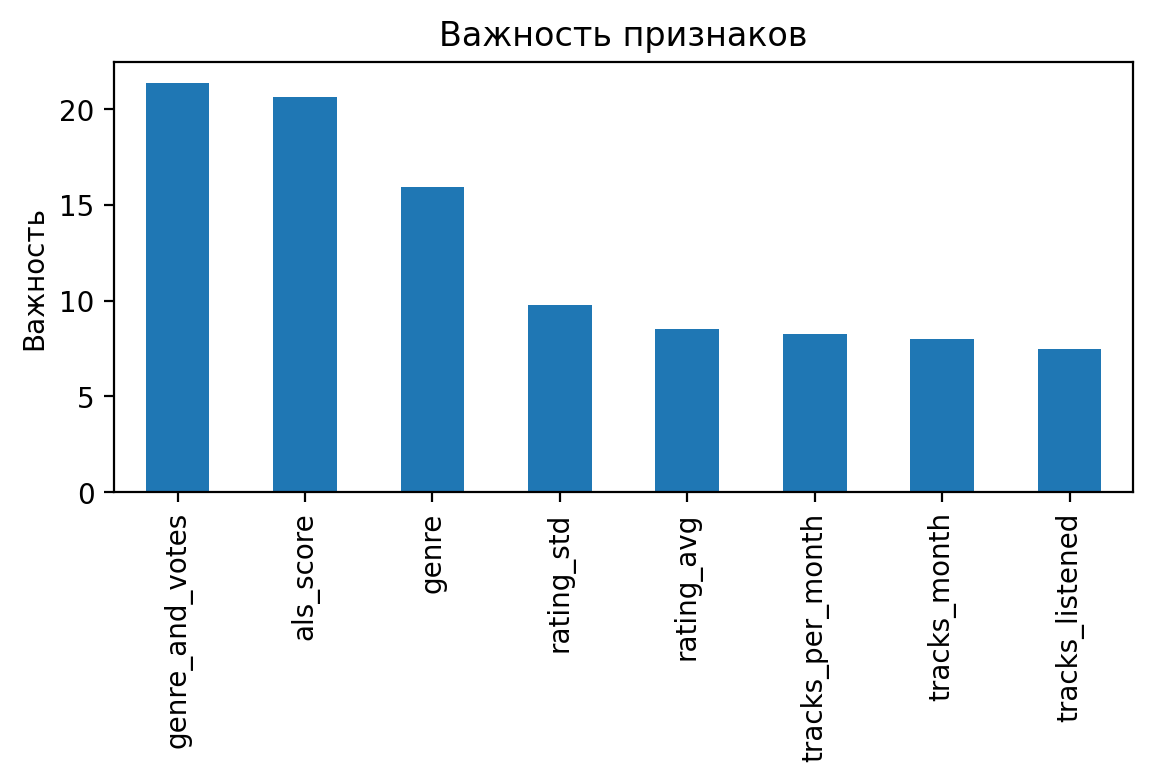

In [180]:
# Выведем диаграмму с оценкой влияния признаков на целевой
imp = pd.Series(cb_model.feature_importances_,
                features)

fig, ax = plt.subplots(figsize=(6,4))
imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Больший вклад внес признак, который был сгенерирован в самом начале, который отражает долю жанра в предпочтениях слушателя. Далее по важности идет оценка базовой моделью ALS.

In [179]:
# Сохраним результат с другим названием
recommendations = candidates_to_rank.copy()

# Сохраним результат в рекомендации
recommendations.to_parquet("recsys/data/recommendations.parquet")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

### Топ популярных

In [71]:
# Загрузим рекомендации
top_k_pop_items = pd.read_parquet('recsys/recommendations/top_popular.parquet')

In [69]:
# Будем использовать холодных пользователей для оценки
events_cold = events[events.user_id.isin(cold_users)]
events_cold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162951 entries, 30711 to 32542623
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     162951 non-null  int32         
 1   track_id    162951 non-null  int32         
 2   track_seq   162951 non-null  int16         
 3   started_at  162951 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 4.0 MB


In [186]:
# Посмотрим на полученные данные
events_cold.head()

,user_id,track_id,rating,started_at,item_id_enc
30711,830,5226222,0.000062,2022-12-29,135
30712,830,5226243,0.000062,2022-12-31,135
34668,1019,1207570,0.018346,2022-12-16,163
34669,1019,43483677,0.009018,2022-12-16,163
34670,1019,45787470,0.028291,2022-12-17,163


In [210]:
# Напомним, как выглядели рекомендации
top_k_pop_items.head()

,track_id,users,avg_rating,track,album,artist,genre
8299,53404,16026,1.000000,Smells Like Teen Spirit,Nevermind,Nirvana,alternative
24143,178529,14802,0.923343,Numb,Meteora,Linkin Park,numetal
417105,33311009,14724,0.958676,Believer,Shape Of Pop,Imagine Dragons,rock
441485,35505245,13938,0.894373,I Got Love,I Got Love,Miyagi & Эндшпиль,rusrap
317594,24692821,12329,0.779974,Way Down We Go,Way down We Go,KALEO,indie


Признак avg_rating является оценкой популярности трека по количеству прослушиваний. Таким образом, можно будет посчитать метрику recall количеству ненулевых значений avg_rating среди холодных пользователей - эта оценка будет отражать истинное количество вхождений "рекомендованных" популярных треков среди тем, которые были прослушаны в действительности.

In [73]:
# Добавим топ рекомендованных треков
cold_users_events_with_recs = events_cold.merge(top_k_pop_items, on="track_id", how="left") 

# Отберем данные, которые удалось получить из рекомендаций без пропусков
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
                 [["user_id", "track_id", "avg_rating"]]

# Отберем данные, где рекомендации не были получены
cold_user_no_recs = cold_users_events_with_recs[cold_user_items_no_avg_rating_idx] \
                  [["user_id", "track_id", "avg_rating"]] 

In [74]:
# Посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.43
Среднее покрытие пользователей: 0.10


In [75]:
# Зададим функцию для расчета recall
def calculate_not_null_mean(series: pd.Series) -> float:
    """Вычисляет среднее значение ненулевых значений"""
    return series.notnull().mean()

# Расчитаем среднее количество вхождений популярных треков для всех пользователей
recall_top_popular = cold_users_events_with_recs.groupby("user_id")["avg_rating"].apply(calculate_not_null_mean).mean()

print(f"Рекомендации топ-100, recall: {recall_top_popular:.5f}")

Рекомендации топ-100, recall: 0.05922


### Персональные рекомендации

Посчитаем метрики, которые были получены в результате рекомендаций ALS.

In [46]:
# Загрузим рекомендации
als_recommendations = pd.read_parquet('recsys/recommendations/personal_als.parquet')

In [47]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    Размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["track_id"].isin(
        events_train["track_id"].unique()
    )
    ]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], 
        how="outer",
    )    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [48]:
events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
    events_train,
    events_test, 
    als_recommendations, 
    top_k=5)

Common users: 114039


In [49]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    """Расчет precision и recall"""
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # Computing precision
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # Computing recall
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [50]:
# precision@5, recall@5
precision, recall = compute_cls_metrics(events_recs_for_binary_metrics)

print(f'Персональные рекомендации, precision: {precision:.4f}, recall: {recall:.4f}')

Персональные рекомендации, precision: 0.0005, recall: 0.0002


In [51]:
# Расчёт покрытия по объектам
cov_als = als_recommendations['track_id'].nunique() / als_recommendations['user_id'].nunique()

print(f"Персональные рекомендации, покрытие: {cov_als:.2f}") 

Персональные рекомендации, покрытие: 0.09


In [52]:
# разметим каждую рекомендацию признаком listened
events_train["listened"] = True

als_recommendations = als_recommendations.merge(events_train, on=["user_id", "track_id"], how="left")
als_recommendations["listened"] = als_recommendations["listened"].fillna(False).astype("bool")

In [53]:
# Проставим ранги
als_recommendations = als_recommendations.sort_values(by=["user_id", "score"], ascending=[True, False])
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

In [54]:
# Посчитаем novelty по пользователям
novelty_5_als = (1-als_recommendations.query("rank <= 5").groupby("user_id")["listened"].mean()).mean()

print(f"Персональные рекомендации, novelty_5: {novelty_5_als:.2f}")

Персональные рекомендации, novelty_5: 0.98


### Итоговые рекомендации

Посчитаем также итоговые рекомендации, где был использован двухстадийный подход.

In [55]:
# Загрузим рекомендации
final_recommendations = pd.read_parquet('recsys/recommendations/recommendations.parquet')

In [57]:
# Получим метрики для финальных рекомендаций
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"Итоговые рекомендации, precision: {cb_precision_5:.4f}, recall: {cb_recall_5:.4f}")

Common users: 83121
Итоговые рекомендации, precision: 0.0006, recall: 0.0005


In [58]:
# Расчёт покрытия по объектам
cov_final = final_recommendations['track_id'].nunique() / final_recommendations['user_id'].nunique()

print(f"Итоговые рекомендации, покрытие: {cov_final:.2f}") 

Итоговые рекомендации, покрытие: 0.20


In [59]:
# разметим каждую рекомендацию признаком listened
events_train["listened"] = True

final_recommendations = final_recommendations.merge(events_train, on=["user_id", "track_id"], how="left")
final_recommendations["listened"] = final_recommendations["listened"].fillna(False).astype("bool")

In [60]:
# Проставим ранги
final_recommendations = final_recommendations.sort_values(by=["user_id", "cb_score"], ascending=[True, False])
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

In [61]:
# Посчитаем novelty по пользователям
novelty_5_final = (1-final_recommendations.query("rank <= 5").groupby("user_id")["listened"].mean()).mean()

print(f"Итоговые рекомендации, novelty_5: {novelty_5_final:.3f}")

Итоговые рекомендации, novelty_5: 0.996


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [78]:
# Сделаем сводную таблицу по метрикам

popular_metrics = pd.Series([recall_top_popular], index=["recall_top_popular"], name="top_popular")

personal_als_metrics = pd.Series([precision, recall, cov_als, novelty_5_als], 
                                 index=["precision@5", "recall@5", "coverage", "novelty@5"],
                                 name="personal_als")

final_recs_metrics = pd.Series([cb_precision_5, cb_recall_5,cov_final,novelty_5_final], 
                               index=["precision@5", "recall@5", "coverage", "novelty@5"],
                               name="final_recs")

pd.concat([popular_metrics, personal_als_metrics, final_recs_metrics], axis=1)

,top_popular,personal_als,final_recs
recall_top_popular,0.059223,NaN,NaN
precision@5,NaN,0.000488,0.000568
recall@5,NaN,0.000196,0.000482
coverage,NaN,0.086528,0.197050
novelty@5,NaN,0.980906,0.995821


Результаты получились не самые лучшие по всем метрикам. Это может быть связано с тем, что рекомендации формировались на основе небольшой выборки - учитывались взаимодействия 200000 пользователей (из-за нехватки мощностей цпу). 

Ркомендация топ-популярных треков в целом показывает себя лучше на усеченном датасете, по сравнению с другими метриками.

По поводу низких значений метрик покрытия можно сделать вывод, что в рекомендациях представлена лишь небольшая часть треков из общего набора. Однако это не является серьезной проблемой, поскольку пользователи не обязательно слушают все треки и не всем из них могут быть интересны.

Получен высокий показатель новизны. Здесь также мог сказаться фактор неполного датасета - просто не все взаимодействия учтены, поэтому новые треки рекомендуются чаще.